# Sentiment Analysis using Hugging Face
For this analysis I will use the Hugging Face Pipeline API to classify the reviews as Positive or Negative.

Please note that only English-written reviews will be analyzed, which may introduce a bias towards English-speaking individuals.
The model that will be used for classification is **distilbert/distilbert-base-uncased-finetuned-sst-2-english**
## Analysis
the analysis process will consist of the following steps:
1. Language classification
2. Sentiment classification using Hugging Face API
3. Manual revision of classification results
4. Visualization using WordClouds

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from textblob import TextBlob
from wordcloud import WordCloudz

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')

### Hugging Face pipelines setup

Hugging Face's pipeline for sentiment analysis:

In [ ]:
classifier = pipeline('sentiment-analysis')

Hugging Face's pipeline for language detection:

In [ ]:
model_name = 'papluca/xlm-roberta-base-language-detection'
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)
lang_classifier = pipeline('text-classification', model=model, tokenizer=tokenizer)

### sentiment analysis

In [3]:
rev23 = pd.read_csv('rev23.csv', parse_dates=['date'])

#### Subsample

Only a subsample of the whole dataset will be used for manual revision and API usage reasons

In [ ]:
subsample = rev23.sample(frac=.01).copy()

Distributions through the year of the subsample:

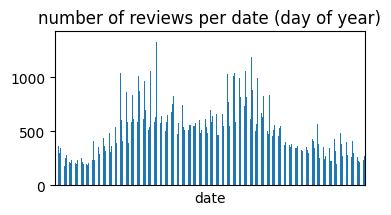

In [65]:
rev23.groupby('date').size().sort_index().plot.bar(figsize=(4,2))
plt.title('number of reviews per date (day of year)')
plt.xticks([])
plt.show()

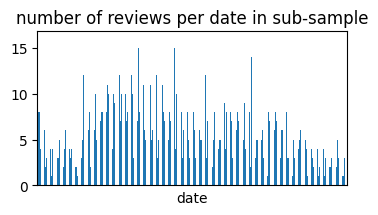

In [66]:
subsample.groupby('date').size().sort_index().plot.bar(figsize=(4,2))
plt.title('number of reviews per date in sub-sample')
plt.xticks([])
plt.show()

#### Language classification

First we will differentiate the language of each review  

In [ ]:
lang_list = lang_classifier(subsample['comments'].to_list())

In [ ]:
subsample['lang'] = [ans['label'] for ans in lang_list]

<Axes: xlabel='lang'>

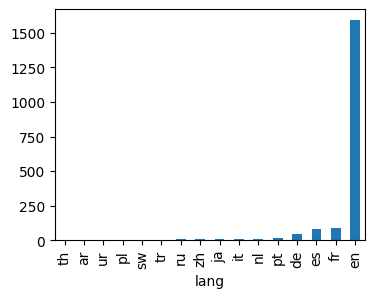

In [72]:
subsample.groupby('lang').size().sort_values().plot.bar(figsize=(4,3))

the reviews in other languages will be saved for future analysis if needed

In [ ]:
eng_rev = subsample.query('lang == "en"').copy()
other_rev = subsample.query('lang != "en"').copy()

In [ ]:
other_rev.to_csv('analysis_data/other_lang/other_rev.csv', index=False) #save df

### Sentiment score

In [ ]:
sent_score = classifier(eng_rev.comments.to_list())

In [ ]:
eng_rev['sent_label'] = [ans['label'] for ans in sent_score]
eng_rev['sent_score'] = [ans['score'] for ans in sent_score]

In [ ]:
eng_rev.to_csv('analysis_data/hf_results/eng_rev.csv', index=False) #save hf results

#### Results analysis

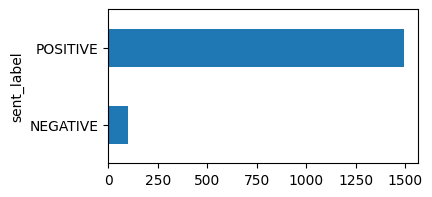

In [96]:
eng_rev.groupby('sent_label').size().plot.barh(figsize=(4,2)); plt.show()

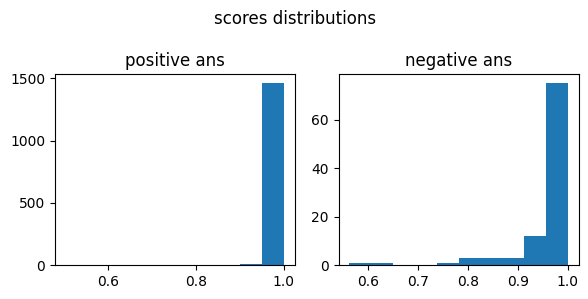

In [97]:
plt.figure(figsize=(6,3))
plt.suptitle('scores distributions')
plt.subplot(1,2,1)
plt.hist(eng_rev.loc[eng_rev['sent_label']=='POSITIVE', 'sent_score'])
plt.title('positive ans')
plt.subplot(1,2,2)
plt.hist(eng_rev.loc[eng_rev['sent_label']=='NEGATIVE', 'sent_score'])
plt.title('negative ans')
plt.tight_layout()

correctness control for reviews with lower score:

In [102]:
eng_rev.loc[(eng_rev['sent_label']=='NEGATIVE') & (eng_rev.sent_score<.95)].sort_values('sent_score').comments.to_list()

['great location close to major subway lines taking you into manhattan and beyond alberts place was clean and had all necessary amenities during our stay we had a minor leak caused by the upstairs neighbors albert was very communicative spoke to the upstairs neighbors to warn them of the leak ordered a dehumidifier and even proactively refunded us a nights stay would absolutely stay here again',
 'its a really great place for the price the subway that heads to manhattan is just a short walking distance so that was super convenient and the neighborhood is pretty quiet surprisingly for being new york haha',
 'this place was a gem the east village is a perfect spot to visit and feel like youre actually in the real nyc while being close enough to tourist destinations if you want to explore that stuff too theres so much to do right when you walk out the door its conveniently located by some great coffee and a whole foods if you need some essentials bryou can basically get to anywhere youd w

In [120]:
eng_rev.loc[(eng_rev['sent_label']=='POSITIVE') & (eng_rev['sent_score']<.90)].sort_values('sent_score', ascending=False)[['comments', 'sent_score']].head(10)

,comments,sent_score
100301,nice apartment well equipped clean it is locat...,0.898220
132586,great location and overall quite clean but som...,0.895239
76150,everything was perfect the most important we h...,0.886294
58735,i would definitely stay here again it was clos...,0.861403
2915,as described good value for the money the home...,0.861059
158755,if you want a place in nyc thats close to time...,0.858788
130387,jamal is very responsive but neglected to let ...,0.845815
54524,overall this was a really nice place quiet cle...,0.827332
87795,i saw some reviews about the room being too sm...,0.820763
103159,we had a nice stay the appartment is located n...,0.820439


positives valued reviews with scores below .9 tend to be not entirely positive, as well as negative reviews with scores below .95, so they will be changed to neutral

In [ ]:
eng_rev.loc[(eng_rev.sent_label=='POSITIVE') & (eng_rev.sent_score<.9), 'sent_label'] = 'NEUTRAL'
eng_rev.loc[(eng_rev.sent_label=='NEGATIVE') & (eng_rev.sent_score<.95), 'sent_label'] = 'NEUTRAL'

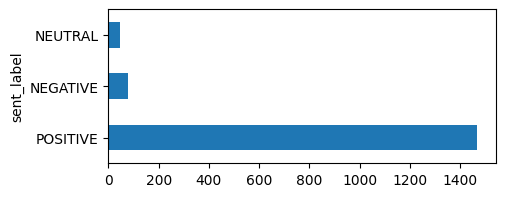

In [124]:
eng_rev.sent_label.value_counts().plot.barh(figsize=(5,2)); plt.show()

In [ ]:
eng_rev.to_csv('analysis_data/eng_rev.csv', index=False) # save

### Wordcloud

In [ ]:
def delete_stopwords(text):
    stop_words = set(stopwords.words('english'))
    words = text.split()
    text = ' '.join([word for word in words if word not in stop_words])
    return text

#### Postive reviews

In [ ]:
eng_rev['no_sw_comm'] = eng_rev.comments.apply(delete_stopwords)

In [ ]:
words = ''
for comment in eng_rev.loc[eng_rev.sent_label=='POSITIVE', 'no_sw_comm']:
    words += comment
    words += ' '

In [ ]:
reviews_adj = ' '.join([word for (word,tag) in TextBlob(words).tags if tag == 'JJ']) #deleting not adjectives using TextBlob

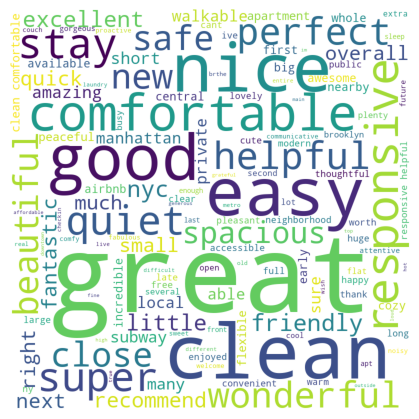

In [133]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(reviews_adj)
                      
plt.figure(figsize = (4, 4), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

#### Bad reviews

In [ ]:
badrev_words = ''
for comment in eng_rev.loc[eng_rev.sent_label=='NEGATIVE', 'no_sw_comm']:
    badrev_words += comment
    badrev_words += ' '

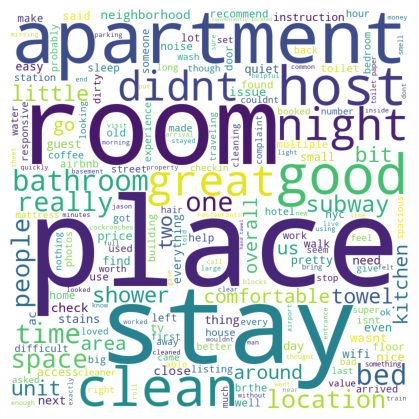

In [135]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(badrev_words)
                      
plt.figure(figsize = (4, 4), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

## Conclusion

This analysis reveals different patterns in what constitutes a good and a bad experience for the user. 

Positive reviews frequently highlight aspects such as **cleanliness**, **comfort**, and excellent **locations**, with guests often praising the **responsiveness** and helpfulness of hosts. On the other hand, negative reviews , while mentioning some of the same issues like cleanliness, communication, and location, show significantly more concerns for issues with the **place** itself, like the bed, kitchen, space, etc.



These insights should help Airbnb hosts to make more informed decision about common issues and what to focus on to create the best experience possible experience
This analysis should also help the platform itself improve the overall guest experience by addressing these common issues and enhancing positive aspects.